<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/Agent_Based_Epidemic_Model_Ensemble_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚠️  ENSEMBLE EPIDEMIC MODEL - Educational Use Only
   Ensemble modeling provides uncertainty quantification
   Do not use for real-world decision making

Running Ensemble Scenario A...
Exported ensemble summary to ensemble_scenarioA_scenarioA_summary.csv
Exported detailed ensemble results to ensemble_scenarioA_scenarioA_detailed.csv
Running Ensemble Scenario B...
Exported ensemble summary to ensemble_scenarioB_scenarioB_summary.csv
Exported detailed ensemble results to ensemble_scenarioB_scenarioB_detailed.csv


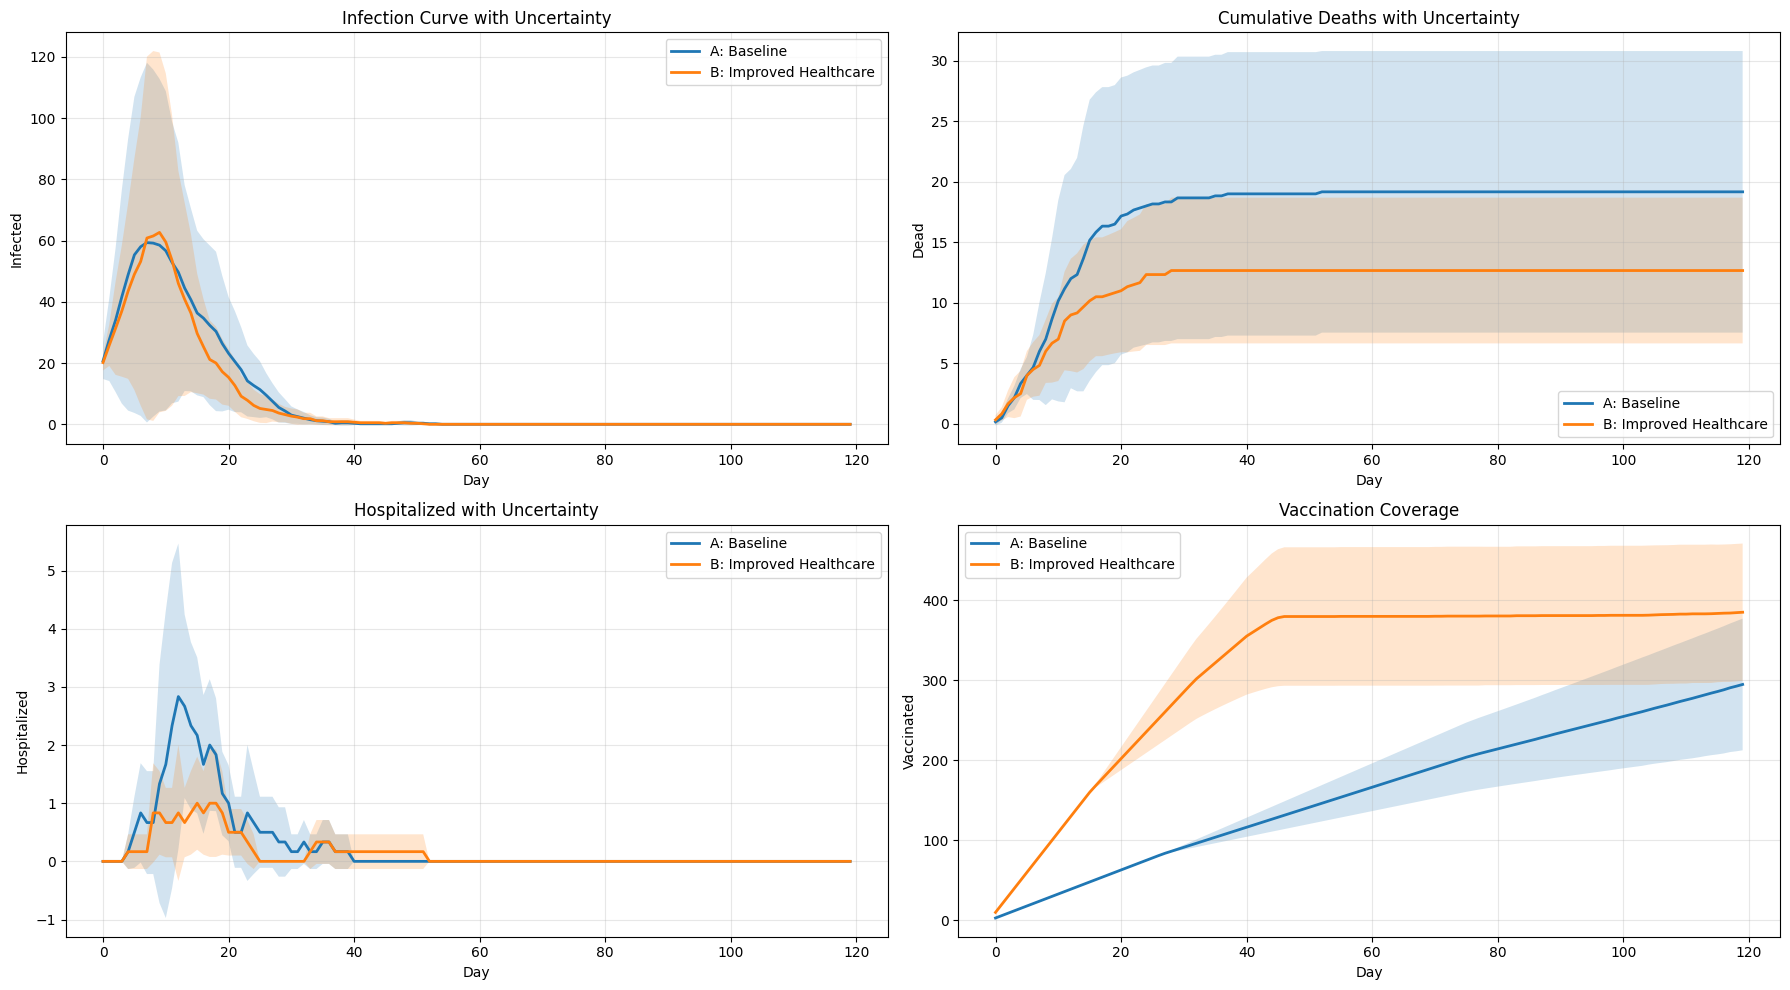

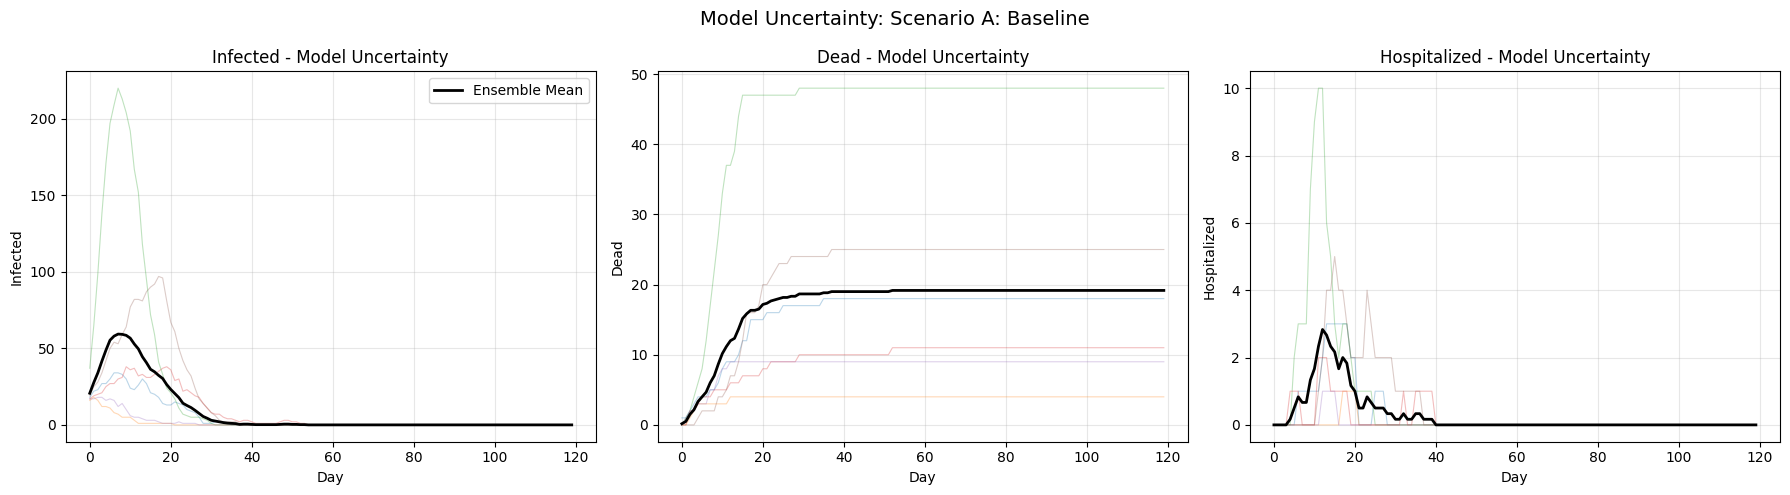

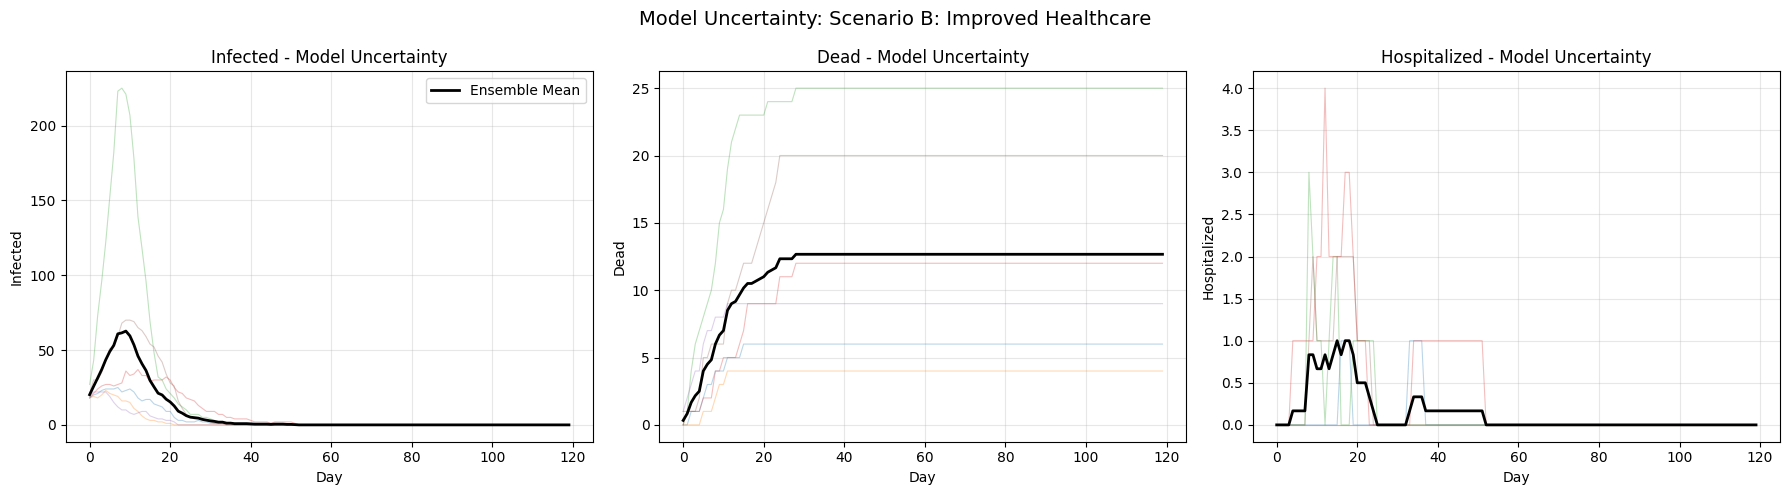


ENSEMBLE MODELING ADVANTAGES:
- Quantifies uncertainty from model structure and parameters
- More robust predictions through model averaging
- Identifies sensitive parameters through ensemble spread
- Provides confidence intervals for all outputs


In [3]:
"""
Agent-Based Epidemic Model with Ensemble Modeling

Features:
- Ensemble modeling with multiple model types and parameter sets
- Agents with age groups (Young, Adult, Elderly) and heterogenous parameters
- Contact network (random + household clusters)
- Stochastic infection per contact, illness duration, reinfection due to waning immunity
- Vaccination rollout with prioritization and vaccine efficacy
- Hospital + ICU with capacity, queues, and staff shortages affecting mortality
- Non-pharmaceutical interventions: lockdown, masks
- Ensemble uncertainty quantification and model averaging
- Scenario runner supporting multiple replications and CSV export
- Dashboard plotting for ensemble comparisons

Author: Dr. Temesgen Deressa: November 2025
Enhanced with Ensemble Modeling
"""

import random
import math
import csv
from collections import defaultdict, deque
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Tuple, Any, Callable
from abc import ABC, abstractmethod
import warnings

# ---------------------------
# ENSEMBLE PARAMETERS
# ---------------------------
ENSEMBLE_PARAMS = {
    "ensemble_size": 5,
    "model_types": ["baseline", "network_variant", "behavioral"],
    "uncertainty_quantification": True,
    "confidence_level": 0.95,
    "ensemble_weighting": "equal",  # "equal", "performance", "expert"
    "calibration_data": None,  # Optional observed data for weighting
}

# ---------------------------
# BASE PARAMETERS (tunable) with uncertainty ranges
# ---------------------------
DEFAULT_PARAMS = {
    "n_agents": 500,
    "initial_infected": 15,
    "steps": 150,
    "seed": 42,

    # Network parameters with uncertainty ranges
    "p_random_contact": {"mean": 0.01, "range": [0.005, 0.02]},
    "avg_household_size": {"mean": 3, "range": [2, 5]},
    "household_fraction": {"mean": 0.4, "range": [0.3, 0.6]},

    # Age distribution
    "age_weights": {"Young": 0.5, "Adult": 0.35, "Elderly": 0.15},

    # Age-specific parameters with uncertainty
    "age_params": {
        "Young": {
            "susceptibility": {"mean": 1.0, "range": [0.8, 1.2]},
            "recovery_mean_days": {"mean": 7, "range": [5, 10]},
            "mortality_base": {"mean": 0.001, "range": [0.0005, 0.002]}
        },
        "Adult": {
            "susceptibility": {"mean": 1.0, "range": [0.9, 1.1]},
            "recovery_mean_days": {"mean": 10, "range": [8, 14]},
            "mortality_base": {"mean": 0.005, "range": [0.003, 0.008]}
        },
        "Elderly": {
            "susceptibility": {"mean": 0.9, "range": [0.7, 1.0]},
            "recovery_mean_days": {"mean": 14, "range": [10, 20]},
            "mortality_base": {"mean": 0.05, "range": [0.03, 0.08]}
        },
    },

    # Transmission parameters
    "base_transmission_prob": {"mean": 0.05, "range": [0.03, 0.08]},
    "infectious_period_draw": (5, 14),
    "recovery_boost_vaccine": {"mean": 0.5, "range": [0.3, 0.7]},
    "waning_immunity_mean_days": {"mean": 180, "range": [120, 240]},
    "waning_immunity_sd": {"mean": 30, "range": [20, 40]},

    # Hospitalization parameters
    "hospitalization_rate_multiplier": {
        "Young": {"mean": 0.2, "range": [0.1, 0.3]},
        "Adult": {"mean": 0.8, "range": [0.6, 1.0]},
        "Elderly": {"mean": 1.5, "range": [1.2, 2.0]}
    },
    "hospital_capacity": 30,
    "icu_capacity": 8,
    "mortality_if_hospitalized_factor": {"mean": 0.5, "range": [0.3, 0.7]},
    "mortality_if_no_hospital_factor": {"mean": 2.5, "range": [2.0, 3.5]},

    # Vaccination parameters
    "vax_daily_capacity": 4,
    "vax_priority": ["Elderly", "Adult", "Young"],
    "vax_efficacy_infection": {"mean": 0.75, "range": [0.6, 0.85]},
    "vax_efficacy_severity": {"mean": 0.7, "range": [0.5, 0.8]},

    # NPI parameters
    "mask_effectiveness": {"mean": 0.4, "range": [0.2, 0.6]},
    "lockdown_contact_reduction": {"mean": 0.5, "range": [0.3, 0.7]},
    "lockdown_start": None,
    "lockdown_end": None,

    # Simulation controls
    "allow_reinfection": True,
    "run_replications": 1,
    "export_prefix": "abm_results",

    # Ensemble-specific
    "model_type": "baseline",  # baseline, network_variant, behavioral
    "parameter_uncertainty": True,
}

# ---------------------------
# Utility functions
# ---------------------------
def set_seed(seed: int) -> None:
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)

def sample_waning_days(mean: float, sd: float) -> int:
    """Sample waning immunity days with positive normal distribution."""
    val = random.gauss(mean, sd)
    return max(30, int(round(val)))

def weighted_random_choice(weights: Dict[str, float]) -> str:
    """Choose a key based on weights."""
    choices = list(weights.keys())
    probs = list(weights.values())
    return random.choices(choices, weights=probs, k=1)[0]

def sample_parameter(value: Any) -> Any:
    """Sample a parameter value from its uncertainty range if it has one."""
    if isinstance(value, dict) and "mean" in value and "range" in value:
        # Sample from uniform distribution within range
        return random.uniform(value["range"][0], value["range"][1])
    elif isinstance(value, dict) and "mean" in value:
        # If no range specified, use mean
        return value["mean"]
    else:
        # Return as-is if not a parameter with uncertainty
        return value

def extract_mean_parameter(value: Any) -> Any:
    """Extract mean value from parameter if it has uncertainty."""
    if isinstance(value, dict) and "mean" in value:
        return value["mean"]
    else:
        return value

# ---------------------------
# Agent class
# ---------------------------
class Agent:
    def __init__(self, uid: int, age_group: str):
        self.uid = uid
        self.age_group = age_group
        self.state = "S"   # S, E (exposed, optional), I, R, D
        self.days_infected = 0
        self.infectious_days_left = 0
        self.hospitalized = False
        self.in_icu = False
        self.vaccinated = False
        self.vax_day = None
        self.immunity_wane_day = None  # absolute day when immunity wanes
        self.household_id = None

    def infect(self, current_day: int, params: Dict[str, Any]) -> None:
        """Infect agent and set disease progression parameters."""
        if self.state == "S":
            self.state = "I"
            # determine infectious duration: sample around age-specific mean
            mean = params["age_params"][self.age_group]["recovery_mean_days"]
            # simpler: sample symmetric around mean
            dur = max(3, int(random.gauss(mean, mean/4)))
            self.infectious_days_left = dur
            self.days_infected = 0
            # assign waning immunity day for future recovered agents
            waning = sample_waning_days(params["waning_immunity_mean_days"], params["waning_immunity_sd"])
            self.immunity_wane_day = current_day + waning

    def vaccinate(self, current_day: int, params: Dict[str, Any]) -> bool:
        """Vaccinate agent if susceptible. Returns True if successful."""
        if not self.vaccinated and self.state == "S":
            self.vaccinated = True
            self.vax_day = current_day
            # set immunity waning (vaccine immunity as well)
            waning = sample_waning_days(params["waning_immunity_mean_days"], params["waning_immunity_sd"])
            self.immunity_wane_day = current_day + waning
            return True
        return False

    def step_day(self, current_day: int, model: 'BaseABMModel', params: Dict[str, Any]) -> None:
        """Process per-day progression (recovery, mortality, hospital events)."""
        if self.state == "I":
            # decrement infectious days
            self.days_infected += 1
            self.infectious_days_left = max(0, self.infectious_days_left - 1)

            # Determine hospitalization need probabilistically
            if not self.hospitalized:
                hosp_need = self._check_hospitalization_need(params)
                if hosp_need:
                    model.request_hospitalization(self)

            # Check mortality
            if self._check_mortality(params):
                self.state = "D"
                self.hospitalized = False
                model.remove_from_hospital(self)
                return

            # If infectious period over -> recover
            if self.infectious_days_left <= 0:
                self._recover()
                model.remove_from_hospital(self)

        # handle immunity waning (R -> S) if allowed
        if params["allow_reinfection"] and self.state == "R" and self.immunity_wane_day is not None:
            if current_day >= self.immunity_wane_day:
                self._lose_immunity()

    def _check_hospitalization_need(self, params: Dict[str, Any]) -> bool:
        """Check if agent needs hospitalization."""
        base_hosp_prob = 0.01 * params["hospitalization_rate_multiplier"][self.age_group]
        if self.vaccinated:
            base_hosp_prob *= (1 - params["vax_efficacy_severity"])
        return random.random() < base_hosp_prob

    def _check_mortality(self, params: Dict[str, Any]) -> bool:
        """Check if agent dies today."""
        base_mort = params["age_params"][self.age_group]["mortality_base"]
        if self.vaccinated:
            base_mort *= (1 - params["vax_efficacy_severity"])

        # adjust mortality depending on hospital access
        if self.hospitalized:
            mortality_today = base_mort * params["mortality_if_hospitalized_factor"]
        else:
            mortality_today = base_mort * params["mortality_if_no_hospital_factor"]

        return random.random() < mortality_today

    def _recover(self) -> None:
        """Transition agent to recovered state."""
        self.state = "R"
        self.hospitalized = False
        self.in_icu = False

    def _lose_immunity(self) -> None:
        """Transition agent back to susceptible state."""
        self.state = "S"
        self.vaccinated = False
        self.immunity_wane_day = None

# ---------------------------
# Ensemble Model Interface
# ---------------------------
class BaseABMModel(ABC):
    """Abstract base class for ensemble model variants."""

    @abstractmethod
    def __init__(self, params: Dict[str, Any]):
        pass

    @abstractmethod
    def run(self, steps: Optional[int] = None) -> None:
        pass

    @abstractmethod
    def to_dataframe(self) -> pd.DataFrame:
        pass

    @abstractmethod
    def aggregate_metrics(self) -> Dict[str, Any]:
        pass

    @abstractmethod
    def request_hospitalization(self, agent: Agent) -> None:
        pass

    @abstractmethod
    def remove_from_hospital(self, agent: Agent) -> None:
        pass

# ---------------------------
# Original Model (now as Baseline Model)
# ---------------------------
class BaselineABMModel(BaseABMModel):
    def __init__(self, params: Dict[str, Any]):
        self.params = self._sample_uncertain_parameters(params)
        self.day = 0
        self.agents = []
        self.adj = defaultdict(set)
        self.hospital_queue = deque()
        self.hospitalized_agents = []
        self.icu_agents = []
        self.metrics = []
        set_seed(self.params.get("seed", None))
        self._build_population()
        self._build_network()

    def _sample_uncertain_parameters(self, params: Dict[str, Any]) -> Dict[str, Any]:
        """Sample uncertain parameters from their ranges."""
        if not params.get("parameter_uncertainty", True):
            # Use mean values if uncertainty sampling is disabled
            return self._extract_means(params)

        sampled = {}

        # Process all parameters recursively
        for key, value in params.items():
            if key == "avg_household_size":
                # Special handling for household size - must be integer
                if isinstance(value, dict) and "mean" in value and "range" in value:
                    sampled[key] = max(2, int(round(random.uniform(value["range"][0], value["range"][1]))))
                elif isinstance(value, dict) and "mean" in value:
                    sampled[key] = int(round(value["mean"]))
                else:
                    sampled[key] = value

            elif key == "age_params":
                # Process age parameters
                sampled[key] = {}
                for age_group, age_params in value.items():
                    sampled[key][age_group] = {}
                    for param_name, param_value in age_params.items():
                        sampled[key][age_group][param_name] = sample_parameter(param_value)

            elif key == "hospitalization_rate_multiplier":
                # Process hospitalization multipliers
                sampled[key] = {}
                for age_group, multiplier in value.items():
                    sampled[key][age_group] = sample_parameter(multiplier)

            elif key in ["infectious_period_draw", "vax_priority", "lockdown_start", "lockdown_end",
                        "allow_reinfection", "run_replications", "export_prefix", "model_type",
                        "parameter_uncertainty", "seed", "n_agents", "initial_infected", "steps",
                        "hospital_capacity", "icu_capacity", "vax_daily_capacity"]:
                # These parameters don't have uncertainty or are not numeric
                sampled[key] = value

            else:
                # Sample scalar parameters
                sampled[key] = sample_parameter(value)

        return sampled

    def _extract_means(self, params: Dict[str, Any]) -> Dict[str, Any]:
        """Extract mean values from uncertain parameters."""
        extracted = {}

        for key, value in params.items():
            if key == "avg_household_size":
                if isinstance(value, dict) and "mean" in value:
                    extracted[key] = int(round(value["mean"]))
                else:
                    extracted[key] = value

            elif key == "age_params":
                extracted[key] = {}
                for age_group, age_params in value.items():
                    extracted[key][age_group] = {}
                    for param_name, param_value in age_params.items():
                        extracted[key][age_group][param_name] = extract_mean_parameter(param_value)

            elif key == "hospitalization_rate_multiplier":
                extracted[key] = {}
                for age_group, multiplier in value.items():
                    extracted[key][age_group] = extract_mean_parameter(multiplier)

            else:
                extracted[key] = extract_mean_parameter(value)

        return extracted

    def _build_population(self) -> None:
        """Create agents with age distribution."""
        n = self.params["n_agents"]
        for i in range(n):
            age_group = weighted_random_choice(self.params["age_weights"])
            self.agents.append(Agent(i, age_group))

    def _build_network(self) -> None:
        """Build contact network with households and random connections."""
        n = len(self.agents)
        p = self.params["p_random_contact"]

        # Create household clusters
        self._build_household_network(n)

        # Add random ER edges
        self._build_random_network(n, p)

    def _build_household_network(self, n: int) -> None:
        """Build household clusters."""
        num_household = int((self.params["household_fraction"] * n) / self.params["avg_household_size"])
        idxs = list(range(n))
        random.shuffle(idxs)

        for h_id in range(num_household):
            hs = []
            for _ in range(self.params["avg_household_size"]):
                if idxs:
                    hs.append(idxs.pop())

            # Assign household ID and create fully connected network
            for agent_idx in hs:
                self.agents[agent_idx].household_id = h_id
            self._connect_household_members(hs)

    def _connect_household_members(self, household_members: List[int]) -> None:
        """Fully connect all members of a household."""
        for i, agent1 in enumerate(household_members):
            for agent2 in household_members[i+1:]:
                self.adj[agent1].add(agent2)
                self.adj[agent2].add(agent1)

    def _build_random_network(self, n: int, p: float) -> None:
        """Build random ER network edges."""
        for i in range(n):
            for j in range(i+1, n):
                if random.random() < p:
                    self.adj[i].add(j)
                    self.adj[j].add(i)

    def seed_infection(self) -> None:
        """Infect initial agents."""
        initial = min(self.params["initial_infected"], len(self.agents))
        for i in random.sample(range(len(self.agents)), initial):
            self.agents[i].infect(self.day, self.params)

    def daily_vaccination(self) -> None:
        """Vaccinate agents according to prioritization and daily capacity."""
        doses = self.params["vax_daily_capacity"]
        priority = self.params["vax_priority"]

        candidates = [a for a in self.agents if a.state == "S" and not a.vaccinated]

        for group in priority:
            group_cands = [a for a in candidates if a.age_group == group]
            random.shuffle(group_cands)

            while doses > 0 and group_cands:
                a = group_cands.pop()
                if a.vaccinate(self.day, self.params):
                    candidates.remove(a)
                    doses -= 1

            if doses <= 0:
                break

    def apply_npi_modifiers(self) -> Tuple[float, float]:
        """Compute transmission and contact modifiers based on NPIs."""
        trans_mod = 1.0
        contacts_mod = 1.0

        # masks reduce transmission multiplicatively
        if self.params.get("mask_policy", False):
            trans_mod *= (1.0 - self.params["mask_effectiveness"])

        # lockdown reduces random contact edges by factor
        if (self.params["lockdown_start"] is not None and
            self.params["lockdown_start"] <= self.day <= (self.params["lockdown_end"] or float('inf'))):
            contacts_mod *= (1.0 - self.params["lockdown_contact_reduction"])

        return trans_mod, contacts_mod

    def request_hospitalization(self, agent: Agent) -> None:
        """Request hospitalization for an agent."""
        if agent not in self.hospital_queue and not agent.hospitalized:
            self.hospital_queue.append(agent)

    def remove_from_hospital(self, agent: Agent) -> None:
        """Remove agent from hospital and ICU."""
        if agent in self.hospitalized_agents:
            self.hospitalized_agents.remove(agent)
        if agent in self.icu_agents:
            self.icu_agents.remove(agent)
        # Also remove from queue if present
        if agent in self.hospital_queue:
            self.hospital_queue.remove(agent)

    def _update_hospital_admissions(self) -> None:
        """Update hospital and ICU admissions based on capacity."""
        # Admit to hospital up to capacity
        while (len(self.hospitalized_agents) < self.params["hospital_capacity"] and
               self.hospital_queue):
            agent = self.hospital_queue.popleft()
            if agent.state == "I" and agent not in self.hospitalized_agents:
                self.hospitalized_agents.append(agent)
                agent.hospitalized = True

        # Admit to ICU up to capacity (prioritize elderly)
        while len(self.icu_agents) < self.params["icu_capacity"]:
            candidates = [a for a in self.hospitalized_agents
                         if a.age_group == "Elderly" and not a.in_icu]
            if not candidates:
                break
            agent = random.choice(candidates)
            agent.in_icu = True
            self.icu_agents.append(agent)

    def step(self) -> None:
        """Run one day of simulation."""
        # Vaccination first (can change susceptibility same day)
        self.daily_vaccination()

        trans_mod, contacts_mod = self.apply_npi_modifiers()

        # Infection spread
        self._spread_infection(trans_mod, contacts_mod)

        # Update hospital admissions
        self._update_hospital_admissions()

        # Step each agent's progression (recovery/death)
        for agent in list(self.agents):
            agent.step_day(self.day, self, self.params)

        # Collect daily metrics
        self.metrics.append(self.aggregate_metrics())
        self.day += 1

    def _spread_infection(self, trans_mod: float, contacts_mod: float) -> None:
        """Spread infection through contacts."""
        infected_agents = [a for a in self.agents if a.state == "I"]
        if not infected_agents:
            return

        susceptible_agents = [a for a in self.agents if a.state == "S"]

        for agent in susceptible_agents:
            if self._check_infection(agent, trans_mod, contacts_mod):
                agent.infect(self.day, self.params)

    def _check_infection(self, agent: Agent, trans_mod: float, contacts_mod: float) -> bool:
        """Check if agent gets infected from contacts."""
        neighbors = list(self.adj[agent.uid])

        for nb_idx in neighbors:
            # Apply contact reduction during lockdown
            if contacts_mod < 1.0 and random.random() > contacts_mod:
                continue

            nb_agent = self.agents[nb_idx]
            if nb_agent.state == "I" and self._transmission_occurs(agent, nb_agent, trans_mod):
                return True

        return False

    def _transmission_occurs(self, susceptible: Agent, infected: Agent, trans_mod: float) -> bool:
        """Determine if transmission occurs between two agents."""
        base_p = self.params["base_transmission_prob"]
        age_susc = self.params["age_params"][susceptible.age_group]["susceptibility"]
        p_inf = base_p * age_susc * trans_mod

        # vaccine reduces infection chance
        if susceptible.vaccinated:
            p_inf *= (1 - self.params["vax_efficacy_infection"])

        return random.random() < p_inf

    def aggregate_metrics(self) -> Dict[str, Any]:
        """Collect daily metrics."""
        s = sum(1 for a in self.agents if a.state == "S")
        i = sum(1 for a in self.agents if a.state == "I")
        r = sum(1 for a in self.agents if a.state == "R")
        d = sum(1 for a in self.agents if a.state == "D")
        vac = sum(1 for a in self.agents if a.vaccinated)
        hosp = len(self.hospitalized_agents)
        icu = len(self.icu_agents)

        return {
            "day": self.day,
            "Susceptible": s,
            "Infected": i,
            "Recovered": r,
            "Dead": d,
            "Vaccinated": vac,
            "Hospitalized": hosp,
            "ICU": icu
        }

    def run(self, steps: Optional[int] = None) -> None:
        """Run the simulation for specified steps."""
        if steps is None:
            steps = self.params["steps"]

        self.seed_infection()
        for _ in range(steps):
            self.step()

    def to_dataframe(self) -> pd.DataFrame:
        """Convert metrics to pandas DataFrame."""
        return pd.DataFrame(self.metrics)

# ---------------------------
# Alternative Model Variants for Ensemble
# ---------------------------
class NetworkVariantModel(BaselineABMModel):
    """Model variant with different network structure (small-world)."""

    def _build_network(self) -> None:
        """Build small-world network instead of ER + households."""
        n = len(self.agents)
        k = 4  # nearest neighbors
        p_rewire = 0.1  # probability of rewiring

        # Create ring lattice
        for i in range(n):
            for j in range(1, k//2 + 1):
                self.adj[i].add((i + j) % n)
                self.adj[(i + j) % n].add(i)

        # Rewire edges with probability p
        for i in range(n):
            for neighbor in list(self.adj[i]):
                if random.random() < p_rewire:
                    self.adj[i].remove(neighbor)
                    self.adj[neighbor].remove(i)

                    # Add new random connection
                    new_neighbor = random.randint(0, n-1)
                    while new_neighbor == i or new_neighbor in self.adj[i]:
                        new_neighbor = random.randint(0, n-1)

                    self.adj[i].add(new_neighbor)
                    self.adj[new_neighbor].add(i)

class BehavioralModel(BaselineABMModel):
    """Model variant with behavioral responses to infection risk."""

    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)
        self.risk_awareness = [0.0] * len(self.agents)  # 0-1 scale

    def _spread_infection(self, trans_mod: float, contacts_mod: float) -> None:
        """Override to include behavioral risk reduction."""
        infected_agents = [a for a in self.agents if a.state == "I"]
        if not infected_agents:
            return

        # Update risk awareness based on local prevalence
        self._update_risk_awareness()

        susceptible_agents = [a for a in self.agents if a.state == "S"]

        for agent in susceptible_agents:
            if self._check_infection(agent, trans_mod, contacts_mod):
                agent.infect(self.day, self.params)

    def _update_risk_awareness(self) -> None:
        """Update agents' risk awareness based on local infection prevalence."""
        for i, agent in enumerate(self.agents):
            if agent.state == "S":
                # Count infected neighbors
                neighbors = list(self.adj[agent.uid])
                infected_neighbors = sum(1 for nb_idx in neighbors
                                       if self.agents[nb_idx].state == "I")

                if neighbors:
                    local_prevalence = infected_neighbors / len(neighbors)
                    # Update risk awareness with memory (slow adaptation)
                    self.risk_awareness[i] = (0.7 * self.risk_awareness[i] +
                                             0.3 * local_prevalence)

    def _check_infection(self, agent: Agent, trans_mod: float, contacts_mod: float) -> bool:
        """Override to include risk-aware contact reduction."""
        neighbors = list(self.adj[agent.uid])
        agent_risk = self.risk_awareness[agent.uid]

        # Risk-aware agents reduce contacts
        effective_contacts_mod = contacts_mod * (1 - agent_risk * 0.5)

        for nb_idx in neighbors:
            # Apply both policy and behavioral contact reduction
            if effective_contacts_mod < 1.0 and random.random() > effective_contacts_mod:
                continue

            nb_agent = self.agents[nb_idx]
            if nb_agent.state == "I" and self._transmission_occurs(agent, nb_agent, trans_mod):
                return True

        return False

# ---------------------------
# Ensemble Manager
# ---------------------------
class EnsembleManager:
    """Manages ensemble of ABM models with uncertainty quantification."""

    def __init__(self, base_params: Dict[str, Any], ensemble_params: Dict[str, Any]):
        self.base_params = base_params
        self.ensemble_params = ensemble_params
        self.models = []
        self.weights = []
        self.results = []

    def build_ensemble(self) -> None:
        """Build ensemble of models with different structures and parameters."""
        ensemble_size = self.ensemble_params.get("ensemble_size", 5)
        model_types = self.ensemble_params.get("model_types", ["baseline"])

        self.models = []

        for i in range(ensemble_size):
            # Alternate between model types
            model_type = model_types[i % len(model_types)]
            params = self.base_params.copy()
            params["model_type"] = model_type
            params["seed"] = self.base_params.get("seed", 42) + i * 1000

            if model_type == "baseline":
                model = BaselineABMModel(params)
            elif model_type == "network_variant":
                model = NetworkVariantModel(params)
            elif model_type == "behavioral":
                model = BehavioralModel(params)
            else:
                model = BaselineABMModel(params)

            self.models.append(model)

        # Initialize weights
        self.weights = [1.0 / len(self.models)] * len(self.models)

    def run_ensemble(self, steps: Optional[int] = None) -> None:
        """Run all models in the ensemble."""
        self.results = []
        for model in self.models:
            model.run(steps)
            self.results.append(model.to_dataframe())

    def compute_ensemble_weights(self, calibration_data: Optional[pd.DataFrame] = None) -> None:
        """Compute model weights based on performance or other criteria."""
        weighting_scheme = self.ensemble_params.get("ensemble_weighting", "equal")

        if weighting_scheme == "equal" or calibration_data is None:
            self.weights = [1.0 / len(self.models)] * len(self.models)
        elif weighting_scheme == "performance":
            # Weight models by their fit to calibration data
            performances = []
            for result in self.results:
                # Simple RMSE-based performance (you can customize this)
                rmse = self._compute_rmse(result, calibration_data)
                performances.append(1.0 / (rmse + 1e-6))  # Inverse of RMSE

            total_perf = sum(performances)
            self.weights = [p / total_perf for p in performances]

    def _compute_rmse(self, simulated: pd.DataFrame, observed: pd.DataFrame) -> float:
        """Compute RMSE between simulated and observed data."""
        # This is a simplified version - customize based on your calibration data
        common_metrics = set(simulated.columns) & set(observed.columns)
        common_metrics = common_metrics - {'day', 'replication', 'scenario'}

        if not common_metrics:
            return float('inf')

        errors = []
        for metric in common_metrics:
            sim_vals = simulated[metric].values
            obs_vals = observed[metric].values[:len(sim_vals)]  # Truncate to match length

            # Simple RMSE
            mse = np.mean((sim_vals - obs_vals) ** 2)
            errors.append(np.sqrt(mse))

        return np.mean(errors)

    def get_ensemble_summary(self) -> pd.DataFrame:
        """Get ensemble summary with confidence intervals."""
        if not self.results:
            return pd.DataFrame()

        # Combine all results
        combined = pd.concat([df.assign(model_idx=i)
                            for i, df in enumerate(self.results)], ignore_index=True)

        # Compute weighted ensemble statistics
        summary_data = []
        days = combined['day'].unique()

        for day in days:
            day_data = combined[combined['day'] == day]
            day_metrics = {}

            for metric in ['Infected', 'Dead', 'Hospitalized', 'Recovered', 'Vaccinated']:
                if metric in day_data.columns:
                    values = day_data[metric].values
                    weights = np.array([self.weights[int(idx)] for idx in day_data['model_idx']])

                    # Weighted statistics
                    weighted_mean = np.average(values, weights=weights)
                    weighted_variance = np.average((values - weighted_mean)**2, weights=weights)
                    weighted_std = np.sqrt(weighted_variance)

                    # Confidence intervals
                    confidence = self.ensemble_params.get("confidence_level", 0.95)
                    z_score = statistics.NormalDist().inv_cdf((1 + confidence) / 2)
                    ci_lower = weighted_mean - z_score * weighted_std / np.sqrt(len(values))
                    ci_upper = weighted_mean + z_score * weighted_std / np.sqrt(len(values))

                    day_metrics.update({
                        f'{metric}_mean': weighted_mean,
                        f'{metric}_std': weighted_std,
                        f'{metric}_lower': ci_lower,
                        f'{metric}_upper': ci_upper,
                    })

            day_metrics['day'] = day
            summary_data.append(day_metrics)

        return pd.DataFrame(summary_data)

    def to_dataframe(self) -> pd.DataFrame:
        """Get detailed ensemble results as DataFrame."""
        return pd.concat([df.assign(model_idx=i, model_type=type(self.models[i]).__name__)
                         for i, df in enumerate(self.results)], ignore_index=True)

# ---------------------------
# Enhanced Scenario Runner with Ensemble
# ---------------------------
def run_ensemble_experiment(base_params: Dict[str, Any],
                          ensemble_params: Dict[str, Any],
                          scenario_name: str = "base") -> Tuple[EnsembleManager, pd.DataFrame]:
    """Run ensemble experiment for a scenario."""

    ensemble_mgr = EnsembleManager(base_params, ensemble_params)
    ensemble_mgr.build_ensemble()
    ensemble_mgr.run_ensemble()

    # Compute weights if calibration data is available
    calibration_data = ensemble_params.get("calibration_data")
    if calibration_data is not None:
        ensemble_mgr.compute_ensemble_weights(calibration_data)

    # Get ensemble summary
    ensemble_summary = ensemble_mgr.get_ensemble_summary()

    # Export results
    if ensemble_summary is not None and not ensemble_summary.empty:
        csv_name = f"{base_params.get('export_prefix','abm_ensemble')}_{scenario_name}_summary.csv"
        ensemble_summary.to_csv(csv_name, index=False)
        print(f"Exported ensemble summary to {csv_name}")

    # Export detailed results
    detailed_df = ensemble_mgr.to_dataframe()
    detailed_csv = f"{base_params.get('export_prefix','abm_ensemble')}_{scenario_name}_detailed.csv"
    detailed_df.to_csv(detailed_csv, index=False)
    print(f"Exported detailed ensemble results to {detailed_csv}")

    return ensemble_mgr, ensemble_summary

# ---------------------------
# Enhanced Plotting for Ensemble
# ---------------------------
def plot_ensemble_dashboard(ensemble_managers: List[EnsembleManager],
                          titles: List[str],
                          figsize: Tuple[int, int] = (18, 10)) -> None:
    """Plot ensemble comparison dashboard with uncertainty bands."""

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.ravel()

    metrics = [
        ("Infected", "Infection Curve with Uncertainty"),
        ("Dead", "Cumulative Deaths with Uncertainty"),
        ("Hospitalized", "Hospitalized with Uncertainty"),
        ("Vaccinated", "Vaccination Coverage")
    ]

    for idx, (metric, title) in enumerate(metrics):
        for ensemble_mgr, t in zip(ensemble_managers, titles):
            summary = ensemble_mgr.get_ensemble_summary()
            if summary is None or summary.empty:
                continue

            # Plot mean
            axes[idx].plot(summary["day"], summary[f"{metric}_mean"],
                          label=t, linewidth=2)

            # Plot confidence band
            if f"{metric}_lower" in summary.columns:
                axes[idx].fill_between(
                    summary["day"],
                    summary[f"{metric}_lower"],
                    summary[f"{metric}_upper"],
                    alpha=0.2
                )

        axes[idx].set_title(title)
        axes[idx].set_xlabel("Day")
        axes[idx].set_ylabel(metric)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_model_uncertainty(ensemble_mgr: EnsembleManager,
                          scenario_name: str = "Scenario") -> None:
    """Plot individual model trajectories to show uncertainty."""

    detailed_df = ensemble_mgr.to_dataframe()
    metrics = ['Infected', 'Dead', 'Hospitalized']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, metric in enumerate(metrics):
        for model_idx in detailed_df['model_idx'].unique():
            model_data = detailed_df[detailed_df['model_idx'] == model_idx]
            axes[idx].plot(model_data['day'], model_data[metric],
                          alpha=0.3, linewidth=0.8)

        # Plot ensemble mean
        summary = ensemble_mgr.get_ensemble_summary()
        if summary is not None and not summary.empty:
            axes[idx].plot(summary['day'], summary[f'{metric}_mean'],
                          'k-', linewidth=2, label='Ensemble Mean')

        axes[idx].set_title(f'{metric} - Model Uncertainty')
        axes[idx].set_xlabel('Day')
        axes[idx].set_ylabel(metric)
        axes[idx].grid(True, alpha=0.3)
        if idx == 0:
            axes[idx].legend()

    plt.suptitle(f'Model Uncertainty: {scenario_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

# ---------------------------
# Example Ensemble Scenarios
# ---------------------------
if __name__ == "__main__":
    print("⚠️  ENSEMBLE EPIDEMIC MODEL - Educational Use Only")
    print("   Ensemble modeling provides uncertainty quantification")
    print("   Do not use for real-world decision making\n")

    # Ensemble configuration
    ensemble_config = {
        "ensemble_size": 6,
        "model_types": ["baseline", "network_variant", "behavioral"],
        "uncertainty_quantification": True,
        "confidence_level": 0.95,
        "ensemble_weighting": "equal",
    }

    # Base parameters with uncertainty ranges
    base = DEFAULT_PARAMS.copy()
    base.update({
        "seed": 123,
        "steps": 120,
        "run_replications": 1,  # Ensemble handles multiple runs
        "vax_daily_capacity": 3,
        "vax_priority": ["Elderly", "Adult", "Young"],
        "mask_policy": True,
        "lockdown_start": 20,
        "lockdown_end": 40,
        "parameter_uncertainty": True,  # Enable parameter sampling
    })

    # Scenario A: Baseline
    sA = base.copy()
    sA.update({"export_prefix": "ensemble_scenarioA"})

    # Scenario B: Improved healthcare
    sB = base.copy()
    sB.update({
        "hospital_capacity": 80,  # Fixed value, not uncertain
        "vax_daily_capacity": 10,
        "export_prefix": "ensemble_scenarioB",
    })

    # Run ensemble experiments
    print("Running Ensemble Scenario A...")
    ensemble_A, summary_A = run_ensemble_experiment(sA, ensemble_config, "scenarioA")

    print("Running Ensemble Scenario B...")
    ensemble_B, summary_B = run_ensemble_experiment(sB, ensemble_config, "scenarioB")

    # Plot results
    plot_ensemble_dashboard([ensemble_A, ensemble_B],
                          ["A: Baseline", "B: Improved Healthcare"])

    plot_model_uncertainty(ensemble_A, "Scenario A: Baseline")
    plot_model_uncertainty(ensemble_B, "Scenario B: Improved Healthcare")

    print("\n" + "="*60)
    print("ENSEMBLE MODELING ADVANTAGES:")
    print("- Quantifies uncertainty from model structure and parameters")
    print("- More robust predictions through model averaging")
    print("- Identifies sensitive parameters through ensemble spread")
    print("- Provides confidence intervals for all outputs")
    print("="*60)